### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [1]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
#!pip install -U albumentations>=0.3.0 --user 
#!pip install -U --pre segmentation-models --user
!pip install segmentation_models

In [2]:
import segmentation_models as sm

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


# Loading dataset

For this example we will use **Autonomous Driving** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [0]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
from fastai.vision import *

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
DATA_DIR = '/content/drive/My Drive/Colab/Capstone/Data/20k'
DATA_DIR_15k = '/content/drive/My Drive/Colab/Capstone/Data/15k'
!ls '/content/drive/My Drive/Colab/Capstone/Data/20k'

best_model_20k.h5  test_color	 train_color_20k
model_plot.png	   test_label_1  train_label_20k


In [6]:
DATA_DIR_4k = '/content/drive/My Drive/Colab/Capstone/Data/4k'
!ls '/content/drive/My Drive/Colab/Capstone/Data/4k'

test	    train_color_4k  validation_color_2k
test_label  train_label_4k  validation_label_2k


In [0]:
x_train_dir = os.path.join(DATA_DIR, 'train_color_20k')
y_train_dir = os.path.join(DATA_DIR, 'train_label_20k')

x_valid_dir = os.path.join(DATA_DIR_4k, 'validation_color_2k')
y_valid_dir = os.path.join(DATA_DIR_4k, 'validation_label_2k')

x_test_dir = os.path.join(DATA_DIR, 'test_color')
y_test_dir = os.path.join(DATA_DIR, 'test_label_1')

In [0]:
from fastai.vision import *
img_name   = get_image_files(x_train_dir)
label_name = get_image_files(y_train_dir)
get_y_label = lambda x : os.path.join(y_train_dir, f'{x.stem}_instanceIds.png')  

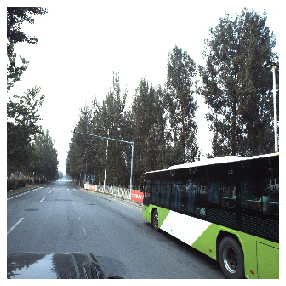

In [15]:
img = open_image(img_name[450])
img.show(figsize=(5, 5))

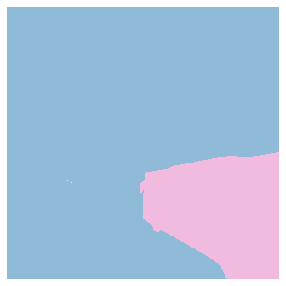

In [16]:
img_label = open_mask(get_y_label(img_name[450]), convert_mode=None)
img_label.show(figsize=(5, 5))

# Dataloader and utility functions 

In [0]:
IMG_HEIGHT=320
IMG_WIDTH=320

In [0]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    plt.close()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    # CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
    #            'tree', 'signsymbol', 'fence', 'car', 
    #            'pedestrian', 'bicyclist', 'unlabelled']
    
    CLASSES = {'car' : 33, 'motorbicycle' : 34, 'bicycle' : 35, 'person' : 36, 'rider' : 37,
               'truck' : 38, 'bus' : 39, 'tricycle' : 40, 'others' : 0, 'rover' : 1, 'sky' : 17,               
               'car_groups' : 161, 'motorbicycle_group' : 162, 'bicycle_group' : 163, 'person_group' : 164,
               'rider_group' : 165, 'truck_group' : 166, 'bus_group' : 167, 'tricycle_group' : 168, 'road' : 49,
               'siderwalk' : 50, 'traffic_cone' : 65, 'road_pile' : 66, 'fence' : 67, 'traffic_light' : 81,
               'pole' : 82, 'traffic_sign' : 83, 'wall' : 84, 'dustbin' : 85, 'billboard' : 86, 'building' : 97,
               'bridge' : 98, 'tunnel' : 99, 'overpass' : 100, 'vegatation' : 113, 'unlabeled' : 255}

    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            stop=-1,
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        get_y_label = lambda x : os.path.join(masks_dir, f'{x.stem}_instanceIds.png')  
        #print(images_dir, masks_dir, classes)

        #self.ids = os.listdir(images_dir)
        self.ids = get_image_files(images_dir)[ : stop]
        #self.images_fps   = get_image_files(images_dir)
        #label_name = get_image_files(masks_dir)
        #print("self.ids ", self.ids)

        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [get_y_label(image_id) for image_id in self.ids]
        print("Image_fps : ", len(self.images_fps))
        print("Masks_fps : ", len(self.masks_fps))
        
        # convert str names to class values on masks
        #self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.class_values = [self.CLASSES[cls.lower()] for cls in classes]
        #print("Class values : ", self.class_values)
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        #print(self.augmentation, self.preprocessing)
    
    def __getitem__(self, i):
        
        # read data
        #print(self.images_fps[i])
        image = cv2.imread(self.images_fps[i])
        #image =  cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(self.masks_fps[i])
        mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        #mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_NEAREST)
        #mask = mask.reshape(IMG_HEIGHT, IMG_WIDTH)
        mask = np.where( np.logical_or(mask < 33, mask > 40), 0, mask)
        #print("Mask : ", np.unique(mask))
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        #print("Masks : ", masks)
        mask = np.stack(masks, axis=-1).astype('float')
        #print("Mask ", np.unique(mask))
        #print("Mask shape : ", mask.shape)
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

Image_fps :  1000
Masks_fps :  1000
Dataset length :  1000


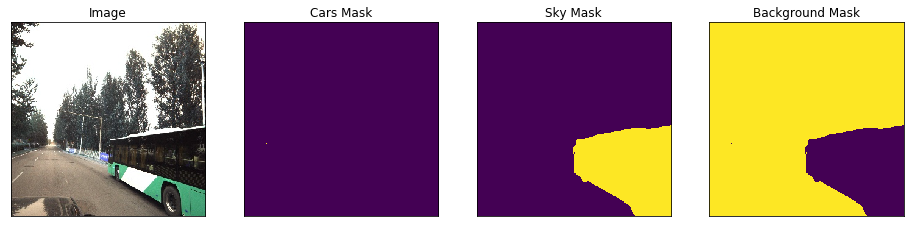

In [19]:
# Lets look at data we have
classes = ['car', 'motorbicycle', 'bicycle', 'person', 
           'rider', 'truck', 'bus', 'tricycle']

dataset = Dataset(x_train_dir, y_train_dir, stop=1000, classes=classes)
image, mask = dataset[450] # get some sample
print("Dataset length : ", len(dataset))

visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze(),
    sky_mask=mask[..., 6].squeeze(),
    background_mask=mask[..., -1].squeeze(),
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [0]:
import albumentations as A

In [0]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [0]:
# Lets look at augmented data we have
classes = ['others', 'car', 'motorbicycle', 'bicycle', 'person', 
           'rider', 'truck', 'bus', 'tricycle']
#dataset = Dataset(x_train_dir, y_train_dir, classes=['car', 'sky'], augmentation=get_training_augmentation())
dataset = Dataset(x_train_dir, y_train_dir, classes=classes)

image, mask = dataset[251] # get some sample
visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze(),
    sky_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., -1].squeeze(),
)

# Segmentation model training

In [0]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 10
CLASSES = ['car', 'bus']
LR = 0.0001
EPOCHS = 8

preprocess_input = sm.get_preprocessing(BACKBONE)

In [42]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create Unet model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

#create FPN model
#model = sm.FPN(BACKBONE, classes=n_classes, activation=activation)











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
44113920/44107200 [==============================] - 0s 0us/step




In [43]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 4 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 4 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 4 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='%s/model_plot.png'%(DATA_DIR), show_shapes=True, show_layer_names=True)

In [0]:
!ls '/content/drive/My Drive/Colab/Capstone/Data/15k'
#!ls DATA_DIR

train_color_15k  train_label_15k  validation_color_1k  validation_label_1k


In [44]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 3, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [0]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    stop = 20000,
    classes=CLASSES, 
    #augmentation=get_training_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    stop = 2000,
    classes=CLASSES, 
    #augmentation=get_validation_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

print("Train dataset : ", len(train_dataset))
print("Valid dataset : ", len(valid_dataset))

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)
#train_dataloader[0][0].shape

# # check shapes for errors
print("Train dataloader 0 0: ", train_dataloader[0][0].shape)
print("Train dataloader 0 1: ", train_dataloader[0][1].shape)
#assert train_dataloader[0][0].shape == (BATCH_SIZE, 2710, 3384, 3)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)
#assert train_dataloader[0][1].shape == (BATCH_SIZE, 2710, 3384, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('%s/best_model_20k.h5'%(DATA_DIR), save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

Image_fps :  20000
Masks_fps :  20000
Image_fps :  2000
Masks_fps :  2000
Train dataset :  20000
Valid dataset :  2000
Train dataloader 0 0:  (10, 320, 320, 3)
Train dataloader 0 1:  (10, 320, 320, 3)


In [0]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

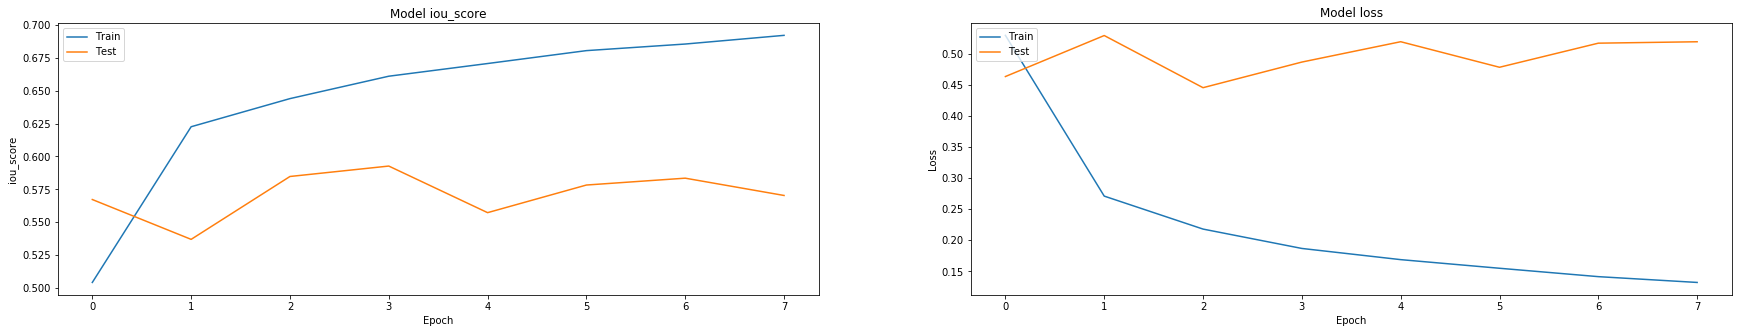

In [0]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)  
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model Evaluation

In [20]:
print(x_test_dir)
print(y_test_dir)

/content/drive/My Drive/Colab/Capstone/Data/20k/test_color
/content/drive/My Drive/Colab/Capstone/Data/20k/test_label_1


In [23]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES,
    #augmentation=get_validation_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

Image_fps :  11
Masks_fps :  11


In [24]:
test_dataset[0][0].shape

(320, 320, 3)

In [37]:
cd '/content/drive/My Drive/Colab/Capstone/Data/20k'

/content/drive/My Drive/Colab/Capstone/Data/20k


In [0]:
import tensorflow as tf
from keras.models import load_model
model = load_model('best_model_20k.h5')

In [0]:
# load best weights
model.load_weights('best_model_20k.h5') 

In [47]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.18973
mean iou_score: 0.73979
mean f1-score: 0.77955


# Visualization of results on test dataset

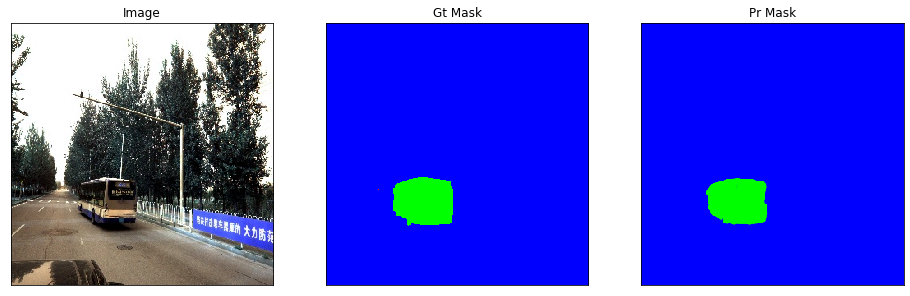

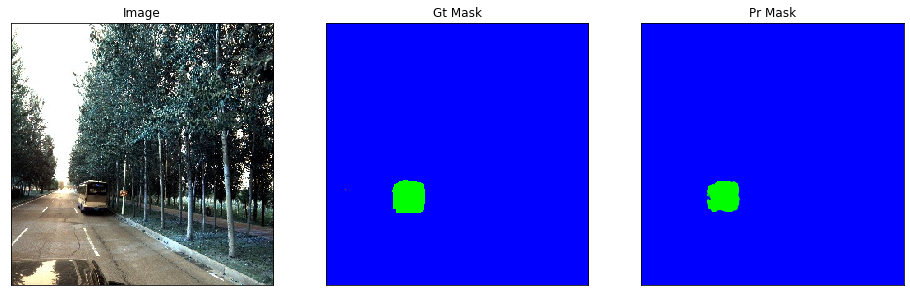

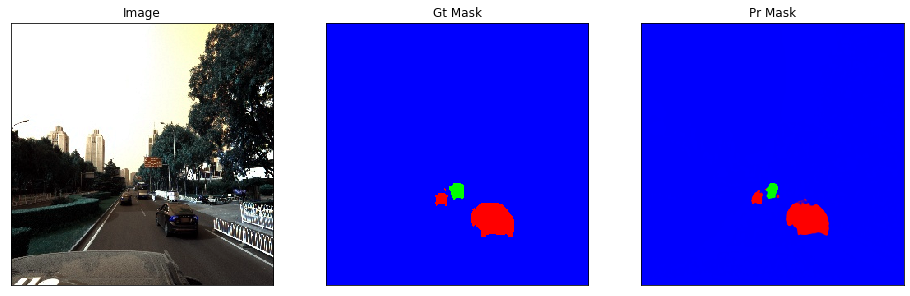

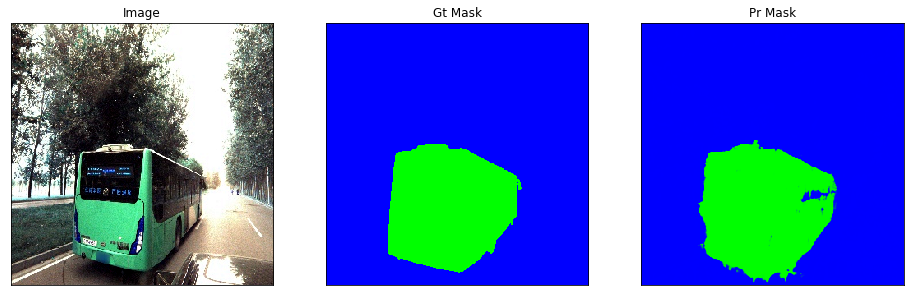

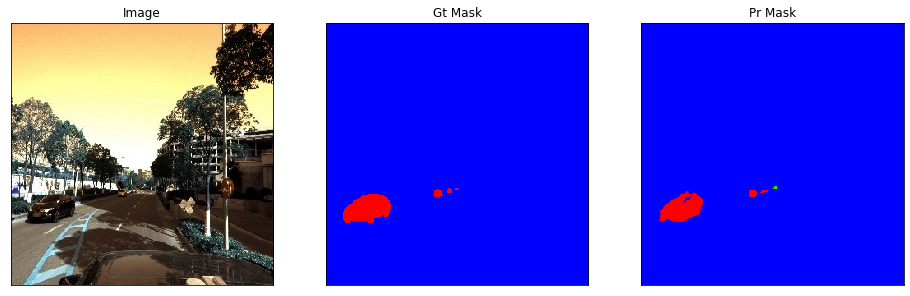

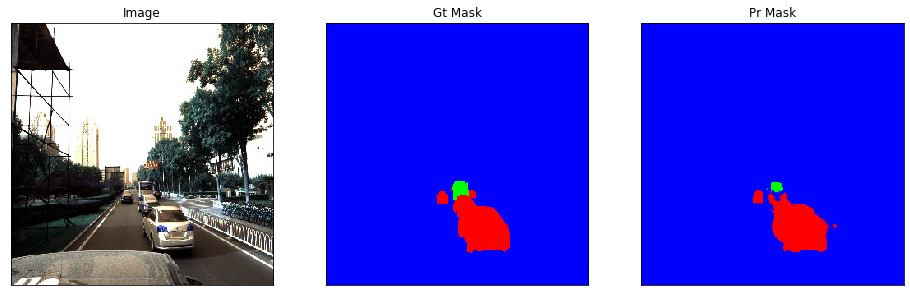

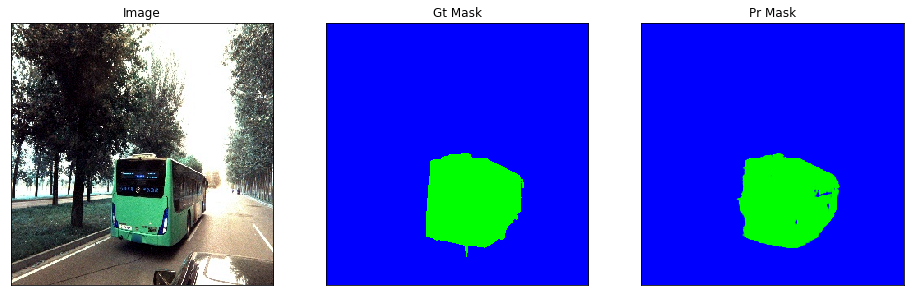

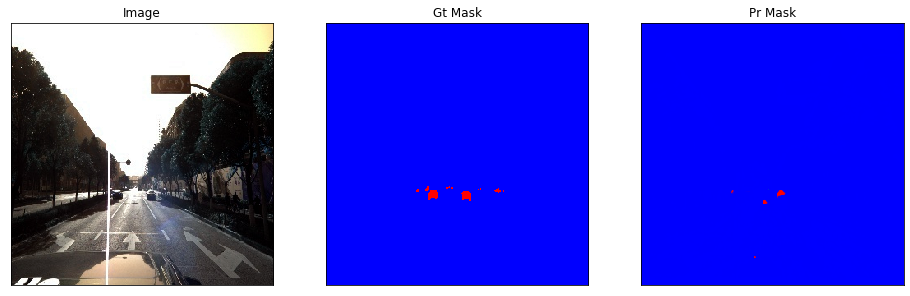

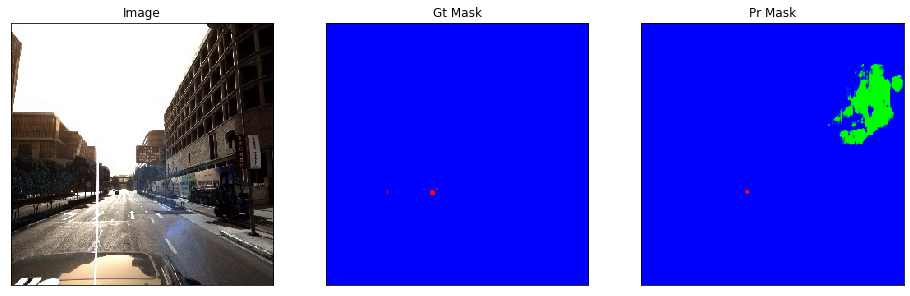

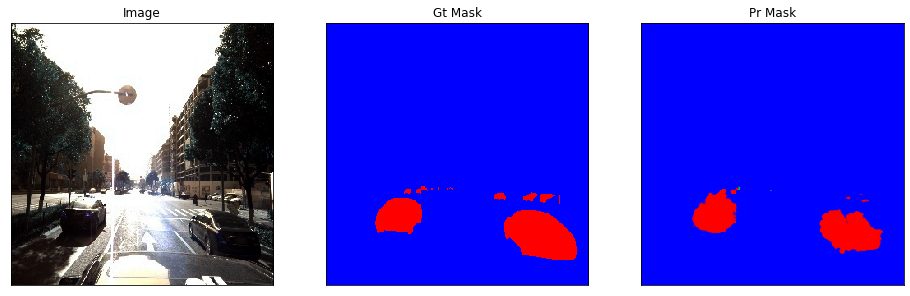

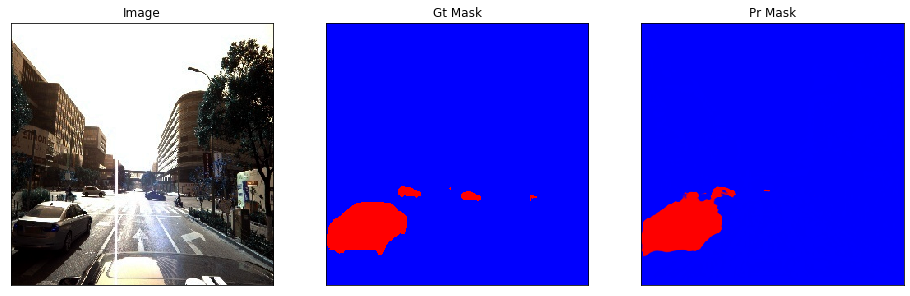

In [48]:
n = 12
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in range(len(test_dataset)):
#for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    ) 